In [1]:
!pip install einops

In [2]:
import os

base_path = "dataset"

folders = ["2_crawling","3_crying","4_dancing","5_eating","7_falling_slide","8_falling","9_playing_w_animals","10_playing_w_toy","12_smiling","15_walking"]

video_label_dict = {}

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith(".mp4"):
            video_path = os.path.join(folder_path, file)
            video_label_dict[video_path] = folder

print(video_label_dict)

{'dataset/2_crawling/crawling016.mp4': '2_crawling', 'dataset/2_crawling/crawling022.mp4': '2_crawling', 'dataset/2_crawling/crawling017.mp4': '2_crawling', 'dataset/2_crawling/crawling007.mp4': '2_crawling', 'dataset/2_crawling/crawling061.mp4': '2_crawling', 'dataset/2_crawling/crawling070.mp4': '2_crawling', 'dataset/2_crawling/crawling076.mp4': '2_crawling', 'dataset/2_crawling/crawling006.mp4': '2_crawling', 'dataset/2_crawling/crawling060.mp4': '2_crawling', 'dataset/2_crawling/crawling004.mp4': '2_crawling', 'dataset/2_crawling/crawling036.mp4': '2_crawling', 'dataset/2_crawling/crawling074.mp4': '2_crawling', 'dataset/2_crawling/crawling067.mp4': '2_crawling', 'dataset/2_crawling/crawling003.mp4': '2_crawling', 'dataset/2_crawling/crawling035.mp4': '2_crawling', 'dataset/2_crawling/crawling010.mp4': '2_crawling', 'dataset/2_crawling/crawling054.mp4': '2_crawling', 'dataset/2_crawling/crawling001.mp4': '2_crawling', 'dataset/2_crawling/crawling019.mp4': '2_crawling', 'dataset/2_

In [3]:
video_label_list = list(video_label_dict.items())
video_paths = list(video_label_dict.keys())
video_labels = list(video_label_dict.values())

In [4]:
from sklearn.preprocessing import LabelEncoder
label_mapping = {
    "2_crawling": 0,
    "3_crying": 1,
    "4_dancing": 2,
    "5_eating": 3,
    "7_falling_slide": 4,
    "8_falling": 5,
    "9_playing_w_animals": 6,
    "10_playing_w_toy": 7,
    "12_smiling": 8,
    "15_walking": 9,
}
label_encoder = LabelEncoder()
label_encoder.fit([label_mapping[label] for label in video_labels])
labels_encoder = label_encoder.transform([label_mapping[label] for label in video_labels])

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training (70%) and temporary (30%) sets
train_video_paths, test_video_paths, train_video_labels, test_video_labels = train_test_split(
    video_paths, labels_encoder, test_size=0.3, stratify=video_labels, random_state=42
)

# Split the temporary data into testing (20% of original data) and validation (10% of original data) sets
val_video_paths, test_video_paths, val_video_labels, test_video_labels = train_test_split(
    test_video_paths, test_video_labels, test_size=2/3, stratify=test_video_labels, random_state=42
)

In [6]:
len(train_video_paths)

213

In [7]:
len(test_video_paths)

62

In [8]:
len(val_video_paths)

30

In [9]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out


class ReAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.reattn_weights = nn.Parameter(torch.randn(heads, heads))

        self.reattn_norm = nn.Sequential(
            Rearrange('b h i j -> b i j h'),
            nn.LayerNorm(heads),
            Rearrange('b i j h -> b h i j')
        )

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # attention

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        # re-attention

        attn = einsum('b h i j, h g -> b g i j', attn, self.reattn_weights)
        attn = self.reattn_norm(attn)

        # aggregate and out

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out
    
class LeFF(nn.Module):
    
    def __init__(self, dim = 192, scale = 4, depth_kernel = 3):
        super().__init__()
        
        scale_dim = dim*scale
        self.up_proj = nn.Sequential(nn.Linear(dim, scale_dim),
                                    Rearrange('b n c -> b c n'),
                                    nn.BatchNorm1d(scale_dim),
                                    nn.GELU(),
                                    Rearrange('b c (h w) -> b c h w', h=14, w=14)
                                    )
        
        self.depth_conv =  nn.Sequential(nn.Conv2d(scale_dim, scale_dim, kernel_size=depth_kernel, padding=1, groups=scale_dim, bias=False),
                          nn.BatchNorm2d(scale_dim),
                          nn.GELU(),
                          Rearrange('b c h w -> b (h w) c', h=14, w=14)
                          )
        
        self.down_proj = nn.Sequential(nn.Linear(scale_dim, dim),
                                    Rearrange('b n c -> b c n'),
                                    nn.BatchNorm1d(dim),
                                    nn.GELU(),
                                    Rearrange('b c n -> b n c')
                                    )
        
    def forward(self, x):
        x = self.up_proj(x)
        x = self.depth_conv(x)
        x = self.down_proj(x)
        return x
    
    
class LCAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        q = q[:, :, -1, :].unsqueeze(2) # Only Lth element use as query

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out
        

In [10]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
#from module import Attention, PreNorm, FeedForward
import numpy as np

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)


  
class ViViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 3, dim_head = 64, dropout = 0.,
                 emb_dropout = 0., scale_dim = 4, ):
        super().__init__()
        
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, num_patches + 1, dim))
        self.space_token = nn.Parameter(torch.randn(1, 1, dim))
        self.space_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.temporal_token = nn.Parameter(torch.randn(1, 1, dim))
        self.temporal_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.dropout = nn.Dropout(emb_dropout)
        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        b, t, n, _ = x.shape

        cls_space_tokens = repeat(self.space_token, '() n d -> b t n d', b = b, t=t)
        x = torch.cat((cls_space_tokens, x), dim=2)
        x += self.pos_embedding[:, :, :(n + 1)]
        x = self.dropout(x)

        x = rearrange(x, 'b t n d -> (b t) n d')
        x = self.space_transformer(x)
        x = rearrange(x[:, 0], '(b t) ... -> b t ...', b=b)

        cls_temporal_tokens = repeat(self.temporal_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_temporal_tokens, x), dim=1)

        x = self.temporal_transformer(x)
        

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        return self.mlp_head(x)
    
    
    

if __name__ == "__main__":
    
    img = torch.ones([1, 16, 3, 224, 224]).cuda()
    
    model = ViViT(224, 16, 100, 16).cuda()
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
    print('Trainable Parameters: %.3fM' % parameters)
    
    out = model(img)
    
    print("Shape of out :", out.shape)      # [B, num_classes]

Trainable Parameters: 4.328M
Shape of out : torch.Size([1, 100])


In [11]:
import cv2
import numpy as np
from torchvision.transforms import Compose, ToTensor

def resize_select_frames(frames, num_frames=16, frame_size=(224, 224)):
    # Resize the frames
    resized_frames = [cv2.resize(frame, frame_size) for frame in frames]

    # Select num_frames consecutive frames
    selected_frames = resized_frames[:num_frames]

    return selected_frames

def video_transform(video_path):
    # Load the video frames using OpenCV
    video = cv2.VideoCapture(video_path)

    # Read the frames
    frames = []
    while True:
        ret, frame = video.read()
        if not ret:
            break
        frames.append(frame)

    # Resize and select frames
    selected_frames = resize_select_frames(frames)

    # Convert the frames to tensors
    transformed_frames = [ToTensor()(frame) for frame in selected_frames]

    # Stack the frames along the first dimension
    video_tensor = torch.stack(transformed_frames)

    return video_tensor

# Assuming you have a video_label_dict with video paths as keys

# Create a custom dataset class
class CustomVideoDataset(torch.utils.data.Dataset):
    def __init__(self, video_label_dict):
        self.video_label_dict = video_label_dict
        self.video_paths = list(video_label_dict.keys())

    def __getitem__(self, index):
        video_path = self.video_paths[index]
        video_tensor = video_transform(video_path)
        label = self.video_label_dict[video_path]
        return video_tensor, label, video_path

    def __len__(self):
        return len(self.video_paths)

In [12]:
model = ViViT(224, 16, 100, 16)
num_classes = 10
model.mlp_head[1] = nn.Linear(in_features=192, out_features=10)
print(model)


ViViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=192, bias=True)
  )
  (space_transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=192, out_features=576, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=192, out_features=192, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=192, out_features=768, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): L

In [13]:
criterion = torch.nn.CrossEntropyLoss()

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [15]:
train_video_dictionary = {}
for path, label in zip(train_video_paths, train_video_labels):
    train_video_dictionary[path] = label
    
test_video_dictionary = {}
for path, label in zip(test_video_paths, test_video_labels):
    test_video_dictionary[path] = label
    
val_video_dictionary = {}
for path, label in zip(val_video_paths, val_video_labels):
    val_video_dictionary[path] = label

In [16]:
train_dataset=CustomVideoDataset(train_video_dictionary)
test_dataset=CustomVideoDataset(test_video_dictionary)
val_dataset=CustomVideoDataset(val_video_dictionary)

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

In [18]:
import matplotlib.pyplot as plt
# Create lists to store the loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the device
model = model.to(device)



num_epochs=50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels, _ in train_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    train_loss_values.append(train_loss)
    train_acc_values.append(train_accuracy/100)
 

    # Validation
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels, _ in test_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    
    test_loss_values.append(test_loss)
    test_acc_values.append(test_accuracy/100)
    
    # Print and log training progress
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

Epoch 1/50: Train Loss: 2.4006, Train Acc: 10.80%, Test Loss: 2.3226, Test Acc: 12.90%
Epoch 2/50: Train Loss: 2.3386, Train Acc: 12.68%, Test Loss: 2.2599, Test Acc: 14.52%
Epoch 3/50: Train Loss: 2.3096, Train Acc: 14.55%, Test Loss: 2.2260, Test Acc: 16.13%
Epoch 4/50: Train Loss: 2.2316, Train Acc: 15.02%, Test Loss: 2.2015, Test Acc: 8.06%
Epoch 5/50: Train Loss: 2.2590, Train Acc: 15.96%, Test Loss: 2.1493, Test Acc: 19.35%
Epoch 6/50: Train Loss: 2.2076, Train Acc: 13.62%, Test Loss: 2.1516, Test Acc: 20.97%
Epoch 7/50: Train Loss: 2.1907, Train Acc: 15.49%, Test Loss: 2.1358, Test Acc: 25.81%
Epoch 8/50: Train Loss: 2.1781, Train Acc: 17.84%, Test Loss: 2.1375, Test Acc: 16.13%
Epoch 9/50: Train Loss: 2.1839, Train Acc: 13.15%, Test Loss: 2.1346, Test Acc: 17.74%
Epoch 10/50: Train Loss: 2.1756, Train Acc: 15.96%, Test Loss: 2.1462, Test Acc: 25.81%
Epoch 11/50: Train Loss: 2.1566, Train Acc: 22.54%, Test Loss: 2.1213, Test Acc: 22.58%
Epoch 12/50: Train Loss: 2.1428, Train Acc

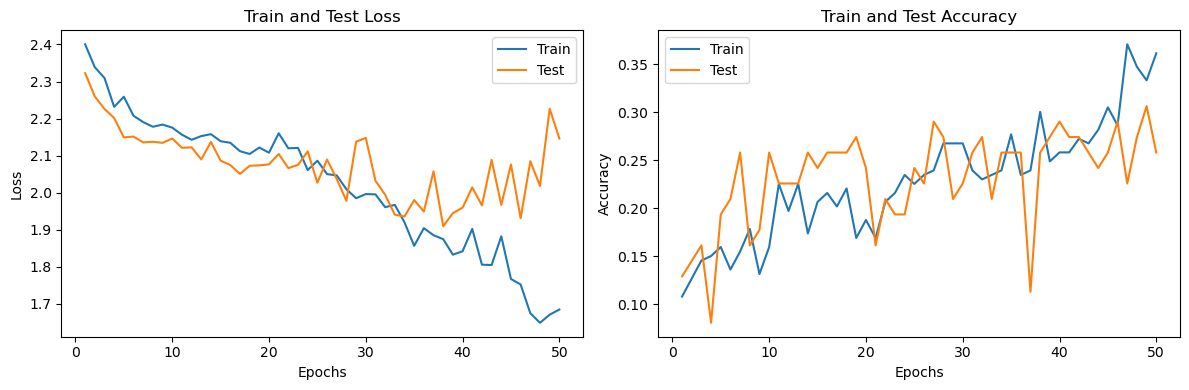

In [19]:
# Plotting the curves
epochs = range(1, num_epochs+1)


# Plotting loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train')
plt.plot(epochs, test_loss_values, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, label='Train')
plt.plot(epochs, test_acc_values, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [20]:
model.eval()
running_loss = 0.0
correct_predictions_top1 = 0
correct_predictions_top5 = 0


with torch.no_grad():
    for inputs, labels, _ in val_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = outputs.max(1)
        correct_predictions_top1 += torch.sum(preds == labels)
        
        # Calculate top-5 accuracy
        _, pred_labels_top5 = torch.topk(outputs, k=5, dim=1)
        correct_predictions_top5 += pred_labels_top5.eq(labels.view(-1, 1).expand_as(pred_labels_top5)).sum().item()
        
        running_loss += loss.item()

epoch_loss = running_loss / len(val_loader.dataset)
epoch_acc_top1 = correct_predictions_top1.double() / len(val_loader.dataset)
epoch_acc_top5 = correct_predictions_top5 / len(val_loader.dataset)

print(f"Top-1 Accuracy: {epoch_acc_top1.item() * 100:.2f}%")
print(f"Top-5 Accuracy: {epoch_acc_top5 * 100:.2f}%")


Top-1 Accuracy: 33.33%
Top-5 Accuracy: 80.00%


In [21]:
model.eval()
running_loss = 0.0
correct_counts = {}
total_counts = {}

with torch.no_grad():
    for inputs, labels, _ in val_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(1)

        running_loss += loss.item()

        for true_label, pred_label in zip(labels, preds):
            if true_label.item() in total_counts:
                total_counts[true_label.item()] += 1
            else:
                total_counts[true_label.item()] = 1

            if true_label.item() == pred_label.item():
                if true_label.item() in correct_counts:
                    correct_counts[true_label.item()] += 1
                else:
                    correct_counts[true_label.item()] = 1

epoch_loss = running_loss / len(val_loader)

print("Top-1 Accuracy by True Label:")
for label in sorted(total_counts.keys()):
    accuracy = correct_counts.get(label, 0) / total_counts[label]
    print(f"True Label: {label}, Accuracy: {accuracy * 100:.2f}%")


Top-1 Accuracy by True Label:
True Label: 0, Accuracy: 66.67%
True Label: 1, Accuracy: 0.00%
True Label: 2, Accuracy: 50.00%
True Label: 3, Accuracy: 50.00%
True Label: 4, Accuracy: 25.00%
True Label: 5, Accuracy: 75.00%
True Label: 6, Accuracy: 33.33%
True Label: 7, Accuracy: 0.00%
True Label: 8, Accuracy: 0.00%
True Label: 9, Accuracy: 25.00%


In [22]:
model.eval()
running_loss = 0.0
correct_counts = {}
total_counts = {}

# Lists to store the video paths, true labels, and predicted labels
video_paths = []
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels, video_path in val_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(1)

        running_loss += loss.item()

        for video_path, true_label, pred_label in zip(video_path, labels, preds):
            if true_label.item() == 2:  # Adjust the condition to match the desired true label
                # Append the video path, true label, and predicted label to the respective lists
                video_paths.append(video_path)
                true_labels.append(true_label.item())
                predicted_labels.append(pred_label.item())

print("Videos with True Label = 2:")
for video_path, true_label, predicted_label in zip(video_paths, true_labels, predicted_labels):
    print(f"Video Path: {video_path}, True Label: {true_label}, Predicted Label: {predicted_label}")

Videos with True Label = 2:
Video Path: dataset/4_dancing/dancing022.mp4, True Label: 2, Predicted Label: 2
Video Path: dataset/4_dancing/dancing010.mp4, True Label: 2, Predicted Label: 8
